In [63]:
from data.visualise import scatter_3d, scatter_yz, show_psf_axial, plot_with_sphere, grid_psfs
from data.datasets import ExperimentalDataSet

from config.datasets import dataset_configs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

dataset = 'other'
exp_dataset = ExperimentalDataSet(dataset_configs[dataset]['sphere'], transform_data=False)


  0%|          | 0/189 [00:00<?, ?it/s]

Reading img...
Loading /home/miguel/Projects/uni/data/smlm_3d/bead_3D_STORM_three_instruments/20210723_beads_1mm/1mm_bead_surface_center_1/1mm_bead_surface_center_1_MMStack_Pos0_substack.ome.tif
Loading /home/miguel/Projects/uni/data/smlm_3d/bead_3D_STORM_three_instruments/20210723_beads_1mm/1mm_bead_surface_center_1/1mm_bead_surface_center_1_MMStack_Pos0_substack.csv


reversing stack!!


18 emitters before filtering
15 emitters after proximity filtering.
15 emitters after borders
68 emitters before filtering
38 emitters after proximity filtering.
38 emitters after borders
281 emitters before filtering
156 emitters after proximity filtering.
156 emitters after borders
531 emitters before filtering
195 emitters after proximity filtering.
189 emitters after borders


100%|██████████| 24/24 [00:00<00:00, 2123.83it/s]


376 emitters before filtering
120 emitters after proximity filtering.
113 emitters after borders
127 emitters before filtering
62 emitters after proximity filtering.
57 emitters after borders
56 emitters before filtering
26 emitters after proximity filtering.
24 emitters after borders


2
(592, 32, 32, 1)
(592, 2)
Rows 60 Cols 10 n_spaces 600 n_psfs 592
(1920, 320)


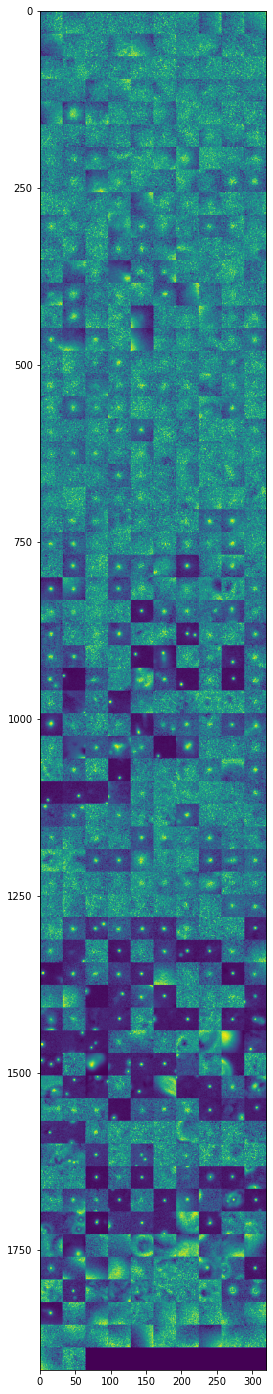

2
(592, 32, 32, 1)
(592, 2)


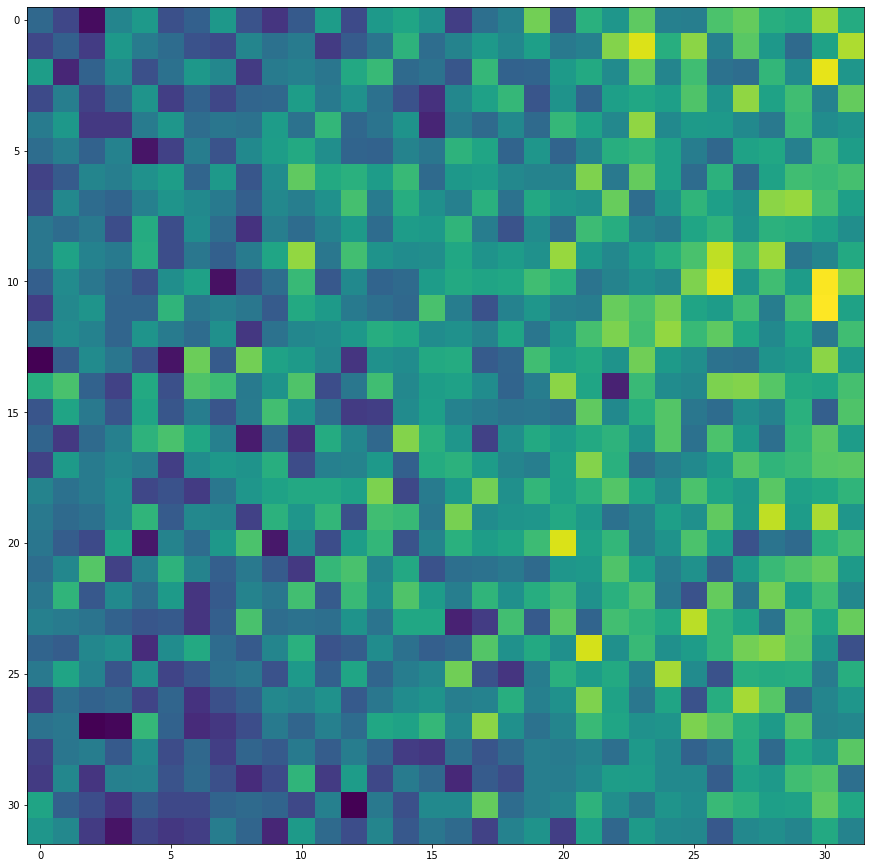

In [64]:
print(len(exp_dataset.data))
print(exp_dataset.data[0].shape)
print(exp_dataset.data[1].shape)

plt.rcParams['figure.figsize'] = [15, 25]

psfs = exp_dataset.data[0]
gridded_psfs = grid_psfs(np.moveaxis(psfs, 3, 1)).squeeze()
print(gridded_psfs.shape)

plt.imshow(gridded_psfs)
plt.show()


print(len(exp_dataset.data))
print(exp_dataset.data[0].shape)
print(exp_dataset.data[1].shape)

for psf in exp_dataset.data[0]:
    plt.imshow(psf)
    plt.show()
    break

(86, 32, 32, 1)
Rows 9 Cols 10 n_spaces 90 n_psfs 86


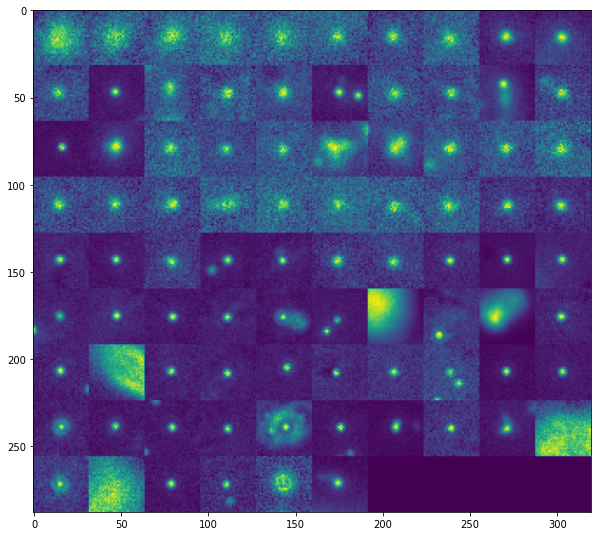

In [105]:


import numpy as np
from scipy.optimize import curve_fit 

def mse(pred, psf):
    return np.mean((pred-psf)**2)

def fit_gaussian(psf):
    psf_dim = psf.shape
    def gaussian_2d(coords, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
        (x, y) = coords
        xo = float(xo)
        yo = float(yo)    
        a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
        b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
        c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
        g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                                + c*((y-yo)**2)))
        return g.ravel()

    initial_amp = psf.max()
    initial_x0 = psf.shape[-1]//2
    initial_y0 = psf.shape[-2]//2
    sigma_x = initial_x0/10
    sigma_y = initial_y0/10
    theta = 1
    offset = psf.max() - psf.min()
    
    initial_guess = (initial_amp, initial_x0, initial_y0, sigma_x, sigma_y, theta, offset)

#     data_noisy = data + 0.2*np.random.normal(size=data.shape)
    
    x = np.linspace(0, psf.shape[0], psf.shape[0])
    y = np.linspace(0, psf.shape[1], psf.shape[1])
    x, y = np.meshgrid(x, y)
    
    popt, pcov = curve_fit(gaussian_2d, (x, y), psf.ravel(), p0=initial_guess, maxfev=10000)
    
    fitted = gaussian_2d((x, y), *popt)
    
    mse_val = mse(fitted, psf.ravel())
    
    mse_cutoff = mse_val < 0.01
    sigmas_non_negative = all([s>0 for s in popt[3:5]])
    sigmas
    amplitude_cutoff = popt[0] > 0.4
    
    popt[1], popt[2] = popt[2], popt[1]
    is_x_in_bounds = 0 <= popt[1] <= psf_dim[0]
    is_y_in_bounds = 0 <= popt[2] <= psf_dim[1]
    
    if not (mse_cutoff and sigmas_non_negative and is_x_in_bounds and is_y_in_bounds and amplitude_cutoff):
        return False

#     print(popt[0], psf_dim[0], popt[1], psf_dim[1])
#     print('amplitude, xo, yo, sigma_x, sigma_y, theta, offset')
#     print(popt, mse_val)
    data_fitted = twoD_Gaussian((x, y), *popt)
    

#     fig, ax = plt.subplots(1, 1)
# #     ax.hold(True)
#     ax.imshow(psf.reshape(psf_dim[0], psf_dim[1]),  
#         extent=(x.min(), x.max(), y.min(), y.max()))
#     ax.contour(x, y, data_fitted.reshape(psf_dim[0], psf_dim[1]), 8, colors='w')
#     plt.show()
    return True

plt.rcParams['figure.figsize'] = [10, 10]

good_psfs = []
for psf in psfs:
    if fit_gaussian(psf.squeeze()):
        good_psfs.append(psf)

good_psfs = np.array(good_psfs)
print(good_psfs.shape)
plt.imshow(grid_psfs(np.moveaxis(good_psfs, 3, 1)).squeeze())

In [ ]:
# Create x and y indices
def twoD_Gaussian(coords, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = coords
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()
    
x = np.linspace(0, 32, 32)
y = np.linspace(0, 32, 32)
x, y = np.meshgrid(x, y)

#create data
data = twoD_Gaussian((x, y), 3, 16, 16, 3, 8, 0, 10)

print(data.shape)
# plot twoD_Gaussian data generated above
plt.figure()
plt.imshow(data.reshape(32, 32))
plt.colorbar()
# add some noise to the data and try to fit the data generated beforehand
initial_guess = (3,100,100,20,40,0,10)

data_noisy = data + 0.2*np.random.normal(size=data.shape)

print(data_noisy.shape)

print(x.shape)
print(y.shape)
print(data_noisy.shape)
popt, pcov = curve_fit(twoD_Gaussian, (x, y), data_noisy, p0=initial_guess)